[View in Colaboratory](https://colab.research.google.com/github/sravya8/DL/blob/master/notebooks/keras_tpu_gpu.ipynb)

#TPU

In [0]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot
%matplotlib inline

def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

  # add empty color dimension
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  
  return (x_train, y_train), (x_test, y_test)

def get_classification_model(in_shape, out_shape):
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=in_shape))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=in_shape))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=in_shape))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(out_shape))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

def plot_predictions(images, predictions, label_names):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = label_names[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)

In [0]:
(x_train, y_train), (x_test, y_test) = get_mnist_data()
label_names = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

model = get_classification_model(x_train.shape[1:], len(label_names))
model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy'])

# Training on the TPU

We're ready to train!   We first construct our model on the TPU, and compile it.

Here we demonstrate that we can use a generator function and `fit_generator` to train the model.  You can also pass in `x_train` and `y_train` to `tpu_model.fit()` instead.

In [32]:
def keras_to_tpu(model):
  return tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
  )
tpu_model = keras_to_tpu(model)
tpu_model.fit(x_train, y_train, 1024,
    epochs=10,
    validation_data=(x_test, y_test))

INFO:tensorflow:Querying Tensorflow master (grpc://10.103.216.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12186225580624608398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2088104370437424634)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1154827247433280825)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17584917479000574092)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15971857831505999500)
INFO:tensorflow:*** Available Device: _DeviceA

In [0]:
#Using fit generator
"""
def train_gen(data, labels, batch_size):
  num = data.shape[0]
  while True:
    offset = np.random.randint(0, num - batch_size)
    yield data[offset:offset+batch_size], labels[offset:offset + batch_size]

tpu_model.fit_generator(
    train_gen(x_train, y_train, 1024),
    epochs=10,
    steps_per_epoch=100,
    validation_data=(x_test, y_test),
)"""


## Inference on CPU

INFO:tensorflow:Copying TPU weights to the CPU


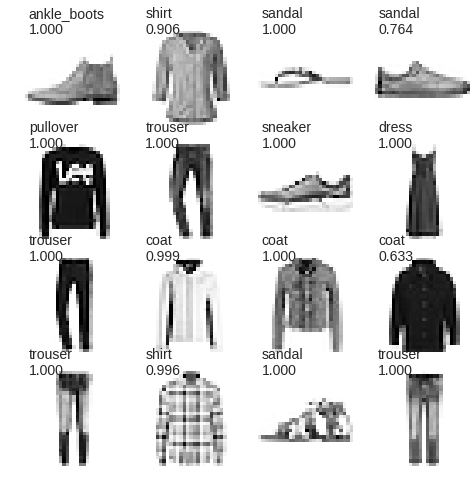

In [18]:
cpu_model = tpu_model.sync_to_cpu()
num = 16
predictions = cpu_model.predict(x_test[:num])
images = np.squeeze(x_test[:num])

plot_predictions(images, predictions, label_names)

## Multi GPU training using Estimator (from keras model)

In [6]:
def model_to_gpu_estimator(model):
  
  strategy = tf.contrib.distribute.MirroredStrategy()
  config = tf.estimator.RunConfig(train_distribute=strategy)
  return tf.keras.estimator.model_to_estimator(
    keras_model=model,
    config=config)

def input_fn():
  data, labels = x_train,y_train
  dataset = tf.data.Dataset.from_tensor_slices((data, labels))
  dataset = dataset.repeat(10)
  dataset = dataset.batch(32)
  return dataset

gpu_estimator = model_to_gpu_estimator(model)
gpu_estimator.train(input_fn=input_fn, steps=10)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f99252fa2d0>, '_model_dir': '/tmp/tmpEHWNOw', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': <tensorflow.contrib.distribute.pyth